In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import scipy
import altair as alt
import matplotlib.pyplot as plt
import shap
import joblib
from tqdm import tqdm

from interaction_effects.marginal import MarginalExplainer
from interaction_effects.plot import summary_plot
import data

In [2]:
primal_effects = []
sample_shap    = []
for i in range(10):
    primal_effects.append(np.load('primal_effects{}.npy'.format(i)))
    sample_shap.append(np.load('sample_shap{}.npy'.format(i)))
primal_effects = np.concatenate(primal_effects, axis=0)
sample_shap = np.concatenate(sample_shap, axis=0)

In [3]:
pca_model = joblib.load('pca.model')

In [4]:
primal_effects.shape

(100, 500)

In [5]:
pca_model.components_.shape

(500, 14932)

In [113]:
X_train_total_orig, y_train_total, \
X_train, y_train, \
X_vald,  y_vald, \
X_test_orig, y_test = data.load_data()

In [114]:
X_test = X_test_orig[:100].values
X_train_total = X_train_total_orig.values
X_test_pca = pca_model.transform(X_test)
X_train_total_pca = pca_model.transform(X_train_total)

In [54]:
shap_values_genes    = np.zeros((sample_shap.shape[0],    X_train_total.shape[1]))
primal_effects_genes = np.zeros((primal_effects.shape[0], X_train_total.shape[1]))
for i in tqdm(range(len(X_train_total))):
    difference = (X_test - X_train_total[i:i+1])
    denom = (X_test_pca - X_train_total_pca[i:i+1])
    normalized_sample_shap = sample_shap / denom
    single_reference_shap  = np.dot(normalized_sample_shap, pca_model.components_) * difference
    shap_values_genes += single_reference_shap
    
    normalized_primal_effects = primal_effects / denom
    single_reference_primal   = np.dot(normalized_primal_effects, pca_model.components_) * difference
    primal_effects_genes += single_reference_primal
    
    assert(np.allclose(np.sum(sample_shap, axis=-1), np.sum(single_reference_shap, axis=-1)))
    assert(np.allclose(np.sum(primal_effects, axis=-1), np.sum(single_reference_primal, axis=-1)))

shap_values_genes /= len(X_train_total)
primal_effects_genes /= len(X_train_total)

100%|██████████| 747/747 [01:14<00:00,  9.97it/s]


In [56]:
assert(np.allclose(np.sum(sample_shap, axis=-1), np.sum(shap_values_genes, axis=-1)))
assert(np.allclose(np.sum(primal_effects, axis=-1), np.sum(primal_effects_genes, axis=-1)))

In [57]:
np.save('primal_effects_genes.npy', primal_effects_genes)
np.save('shap_values_genes.npy', shap_values_genes)

In [60]:
interaction_effects_genes = shap_values_genes - primal_effects_genes

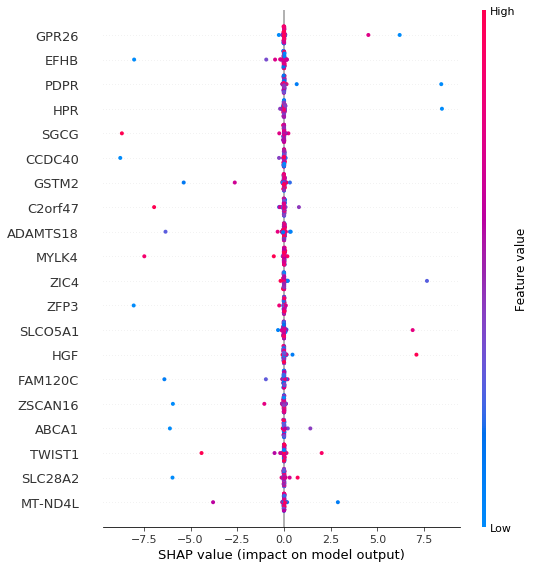

In [75]:
summary_plot(shap_values_genes, X_test, feature_names=X_train.columns)

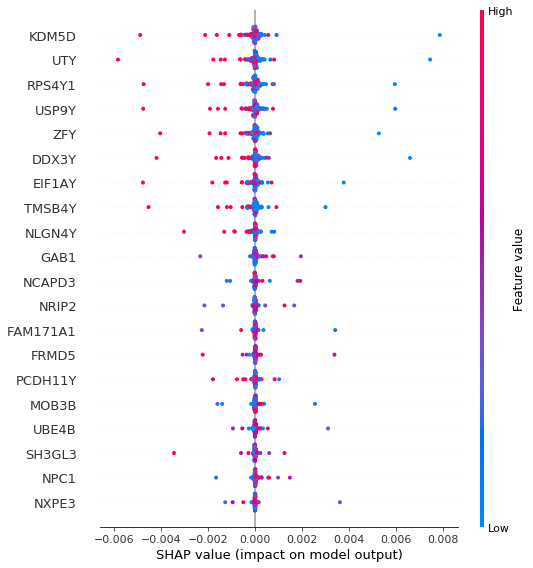

In [71]:
summary_plot(primal_effects_genes, X_test, feature_names=X_train.columns)

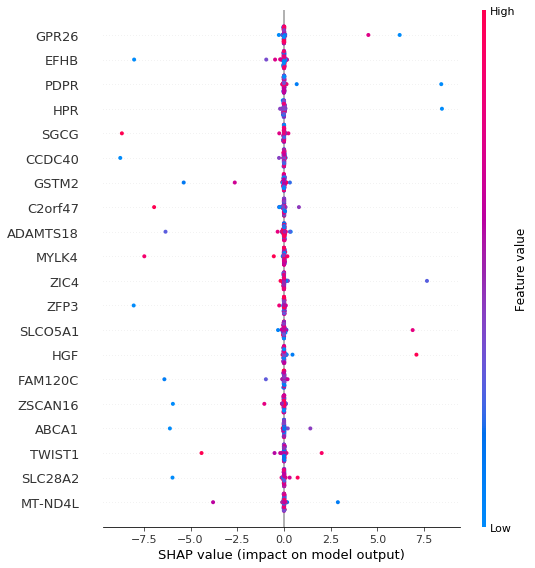

In [74]:
summary_plot(interaction_effects_genes, X_test, feature_names=X_train.columns)

In [96]:
max_num_features = 10
indices = np.argsort(np.max(np.abs(primal_effects_genes), axis=-1))[::-1]
patient_index = indices[0]
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects_genes[patient_index],
    'Interaction Effect': shap_values_genes[patient_index] - primal_effects_genes[patient_index],
    'Sampled Shap Value': shap_values_genes[patient_index],
    'Feature': X_train.columns,
    'Feature Value': X_test[patient_index]
})
ind_df.sort_values(by=['Primal Main Effect'], inplace=True)
ind_df = pd.concat([ind_df.tail(max_num_features), ind_df.head(max_num_features)])
ind_df.drop('Sampled Shap Value', inplace=True, axis='columns')
melted_df = pd.melt(ind_df, id_vars=['Feature', 'Feature Value'], value_name='Sampled SHAP Value', var_name='Effect Type')

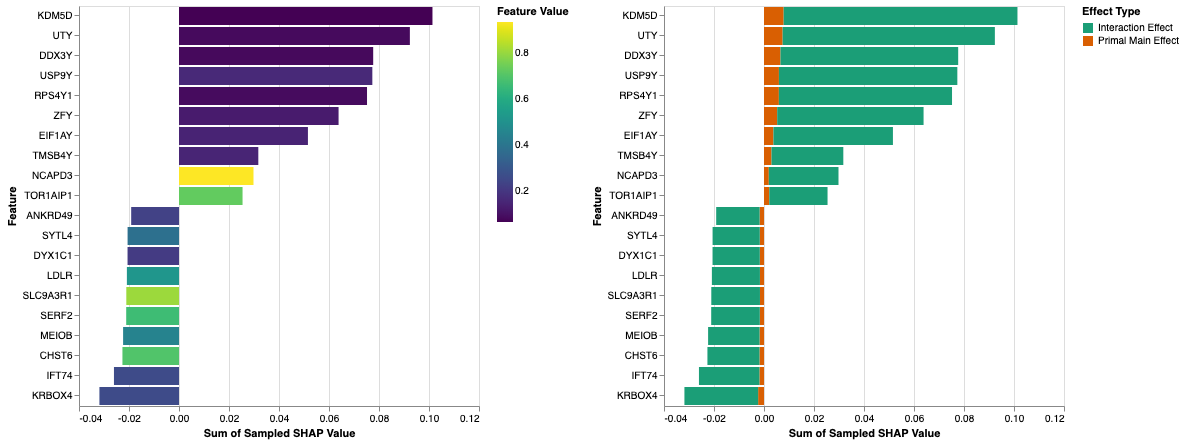

In [97]:
base = alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Sampled SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Sampled SHAP Value",
            order="descending" 
        ))
)

base_descending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='descending')]
)

base_ascending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='ascending')]
)

(base_descending.encode(
    alt.Color('Feature Value:Q', scale=alt.Scale(scheme='viridis'))
))  | base_descending.encode(
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)

In [109]:
import seaborn as sns; sns.set()

In [107]:
trend_df = pd.DataFrame({
    'Feature Value': X_test.flatten(),
    'Main Effect':   primal_effects_genes.flatten(),
    'SHAP Value':    shap_values_genes.flatten(),
    'Interaction Effect': interaction_effects_genes.flatten()
})

In [119]:
sns.reset_orig()

/homes/gws/psturm/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/homes/gws/psturm/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/homes/gws/psturm/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/homes/gws/psturm/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/homes/gws/psturm/miniconda3/lib/python3.7/_collections_abc.py:841: 

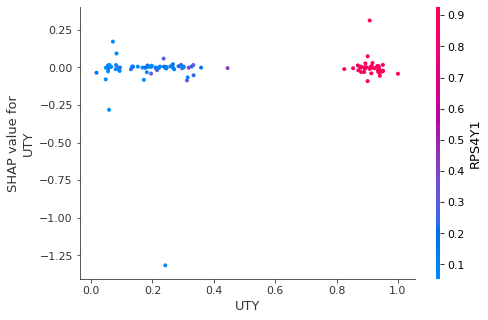

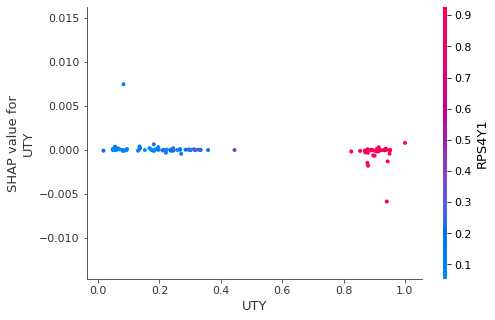

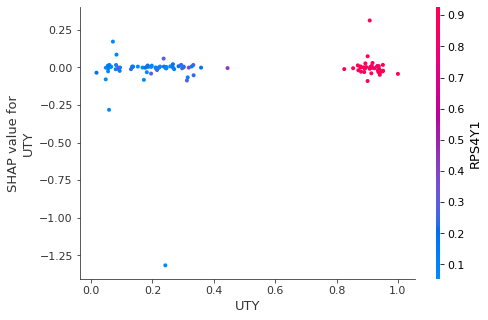

In [123]:
feature = 'UTY'
interaction_feature = 'RPS4Y1'
shap.dependence_plot(feature, shap_values_genes, X_test_orig[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects_genes, X_test_orig[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects_genes, X_test_orig[:100], interaction_index=interaction_feature)